## Project 1: Bikeshare at Lyft
*June 7, 2020*

*Simon LI*

In this report, we will explore the bikeshare datasets to understand how we can increase bikeshare memberships at Lyft.  First, we will perform some data exploration to define a "commuter trip" and indentify the 5 most popular trips on our bikes.  Then, we will look into where we are lacking membership and provide recommendations for new membership offers.

### 0. Import the necessary libraries: Pandas, matplotlib, and Seaborn

The following imports the necessary libraries for processing dataframes from big queries using Pandas and creating visualizations with matplotlib and Seaborn.

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Intial Data Exploration

This report will use two datasets:
* bigquery-public-data.san_francisco.bikeshare_trips
* bigquery-public-data.san_francisco.bikeshare_stations

To start this data exploration, we will create a preview of both datasets.  The following two queries picks out a single trip id or station id and print the results in a dataframe. 

In [90]:
%%bigquery df_trip_data_set

SELECT *
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE trip_id = 944732;

In [91]:
%%bigquery df_station_data_set

SELECT *
FROM `bigquery-public-data.san_francisco.bikeshare_stations`
WHERE station_id = 9;

In [92]:
# Shows the bikeshare_trips dataset
df_trip_data_set

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,944732,2618,2015-09-24 17:22:00+00:00,Mezes,83,2015-09-24 18:06:00+00:00,Mezes,83,653,94063,Customer


In [93]:
# SHows the bikeshare_stations dataset
df_station_data_set

,station_id,name,latitude,longitude,dockcount,landmark,installation_date
0,9,Japantown,37.348742,-121.894715,15,San Jose,2013-08-05


The bikeshare_trips dataset has the trip_id as a key and includes information such as duration of bike ride, start and end stations of a trip, and subscriber type.  Whereas the bikeshare_stations dataset has the station_id as the key and includes information on the landmark and location of the bike stations. The information in these datasets allow us to study how the bikeshare trips vary with time, location, and subscriber type.

### 2. Bikeshare trips vs time

The following three queries show the percentage of trips that occur during each month, week, or day for the past three years.  For the query on months, the script extracts the months from the start_date column, groups the trips according to the months, and then counts the number of trips in each month.  The total number of trips in the dataset is 983,648 and is used to calculate the percentage of trips each month.  Data on the weeks and days are calculated in a similar manner as the months.

In [94]:
%%bigquery df_monthly

SELECT 
    EXTRACT(month from start_date) as months,
    COUNT(trip_id) as trips_started,
    ROUND(COUNT(trip_id) / 983648 *100, 2) as percent_of_total_rides
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY months
ORDER BY percent_of_total_rides DESC;

In [95]:
%%bigquery df_daily

SELECT 
    EXTRACT(dayofweek FROM start_date) as days,
    COUNT(trip_id) as trips_started,
    ROUND(COUNT(trip_id) / 983648 *100, 2) as percent_of_total_rides
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY days
ORDER BY percent_of_total_rides DESC;

In [96]:
%%bigquery df_hourly

SELECT 
    EXTRACT(hour FROM start_date) as hours,
    COUNT(trip_id) as trips_started,
    ROUND(COUNT(trip_id) / 983648 *100, 2) as percent_of_total_rides
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY hours
ORDER BY percent_of_total_rides DESC;

A sample of the monthly data that was extracted is shown below.  Summing the trips_started column shows we have accounted for all the trips.

In [97]:
# Prints the total trips
print('Total trips = ' + str(sum(df_monthly['trips_started'])))

# Shows the monthly dataset
df_monthly

Total trips = 983648


,months,trips_started,percent_of_total_rides
0,8,95576,9.72
1,10,94378,9.59
2,6,91672,9.32
3,7,89539,9.10
4,9,87321,8.88
5,5,86364,8.78
6,4,84196,8.56
7,3,81777,8.31
8,11,73091,7.43
9,1,71788,7.30


Next we will visualize the monthly, daily, and hourly start_trip data using matplotlib and Seaborn.  Three subplots are created with the y-axis representing the distribution of total trips.

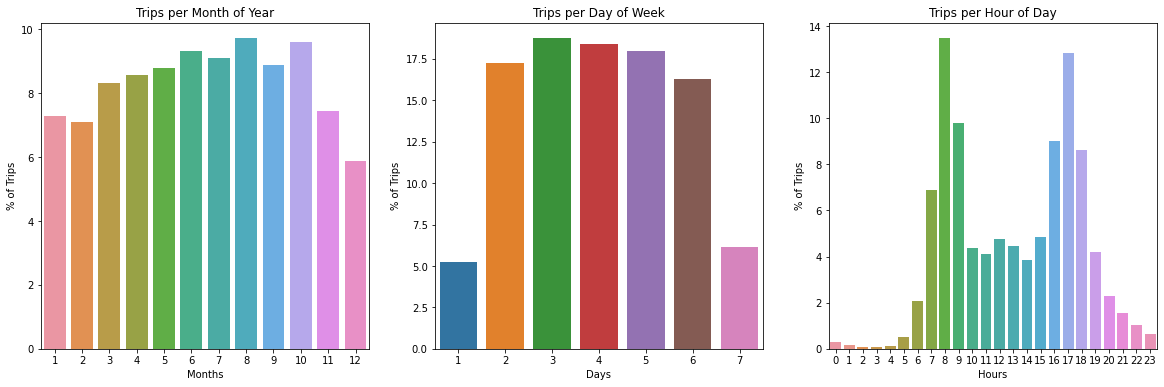

In [98]:
# Initialize the matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Plot the barplots for monthly, daily, and hourly datasets
ax1 = sns.barplot(x="months", y="percent_of_total_rides", data=df_monthly, ax=ax1)
ax2 = sns.barplot(x="days", y="percent_of_total_rides", data=df_daily, ax=ax2)
ax3 = sns.barplot(x="hours", y="percent_of_total_rides", data=df_hourly, ax=ax3)

# Edit the title and labels for each plot
ax1.set_title('Trips per Month of Year')
ax1.set_xlabel('Months')
ax1.set_ylabel('% of Trips')

ax2.set_title('Trips per Day of Week')
ax2.set_xlabel('Days')
ax2.set_ylabel('% of Trips')

ax3.set_title('Trips per Hour of Day')
ax3.set_xlabel('Hours')
ax3.set_ylabel('% of Trips')

# Show the plot
plt.show()

From the bar charts, we can see that the percentage of trips are not uniform throughout the months, days of the week, and hours of a day.  The winter months, November through February, see a slight dip in rides.  During the week, most rides happen between Monday (2) through Friday (6).  Within a day there is bimodal distribution where rides are concentrated in the morning between 7-10am and evening between 4-7pm.  

The combination of these three graphics suggests the majority of trips on our bikes are used during working times and is likely being used by commuters.

Next take a look at location.

### 3. Bikeshare trips vs Location

#### 3a. How do trips vary with city?

The following query looks at both the bikeshare_trips and bikeshare_stations dataset to count the number of unique trips for each landmark (i.e. city).  The query joins both stations using start_station_id and station_id, then returns a data frame in descending order.

In [99]:
%%bigquery df_city

SELECT
    landmark,
    count(trip_id) as trips_started,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations`
ON start_station_id = station_id
GROUP BY landmark
ORDER BY trips_started DESC
;

A sample of the city data is shown below and we have added a column %_trips to include the proportion each city contributes to the total

In [100]:
# Prints the total trips
print('Total trips = ' + str(sum(df_city['trips_started'])))


# Adds the columns %_trips
df_city['%_trips'] = round(df_city['trips_started']/sum(df_city['trips_started']) * 100, 2)
df_city

Total trips = 983648


,landmark,trips_started,%_trips
0,San Francisco,891223,90.60
1,San Jose,52861,5.37
2,Mountain View,24679,2.51
3,Palo Alto,9889,1.01
4,Redwood City,4996,0.51


From the above data table, we can easily see that 90% of our trips are concentrated in San Francisco.  Let's take a deeper look at San Francisco then.

#### 3b. How do trips vary in San Francisco?

To look at the trips specifically in San Francisco, we use the dataset from bikeshare_trips and bikeshare_stations and set the landmark to "San Francisco".  The output is a data frame of trips in every start station in San Francisco.  Then we order the stations by the most trips and limit to the top 10.

In [102]:
%%bigquery df_sf

SELECT
    start_station_id,
    start_station_name,
    count(trip_id) as trips_started,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations`
ON start_station_id = station_id
WHERE landmark = 'San Francisco'
GROUP BY start_station_id, start_station_name
ORDER BY trips_started DESC LIMIT 10
;

We then use pandas dataframe to add a column %_trips_sf for the proportion each station contributes to the total trips in San Francisco.  Additionally, a new row Top 10 in SF is added to sum the top 10 values.

In [103]:
# Add the column %_trips_sf
df_sf['%_trips_sf'] = round(df_sf['trips_started']/df_city['trips_started'][0] * 100, 2)

# Creeate a new row Top 10 in SF
new_row = pd.DataFrame(
    {'start_station_id':' ',
     'start_station_name':'Top 10 in SF', 
     'trips_started':sum(df_sf['trips_started']),
     '%_trips_sf': sum(df_sf['%_trips_sf'])
    },
     index =[10])

# Add the new row to the df_sf dataframe
df_sf = pd.concat([new_row, df_sf]).reset_index(drop = True)

# Show the edited dataframe
df_sf

,start_station_id,start_station_name,trips_started,%_trips_sf
0,,Top 10 in SF,436894,49.03
1,70,San Francisco Caltrain (Townsend at 4th),72683,8.16
2,69,San Francisco Caltrain 2 (330 Townsend),56100,6.29
3,50,Harry Bridges Plaza (Ferry Building),49062,5.51
4,60,Embarcadero at Sansome,41137,4.62
5,61,2nd at Townsend,39936,4.48
6,55,Temporary Transbay Terminal (Howard at Beale),39200,4.40
7,74,Steuart at Market,38531,4.32
8,77,Market at Sansome,35142,3.94
9,65,Townsend at 7th,34894,3.92


Almost 50% of the trips in San Francisco occur in these top 10 locations.  When we put the trips into Google Maps and import the image we see:

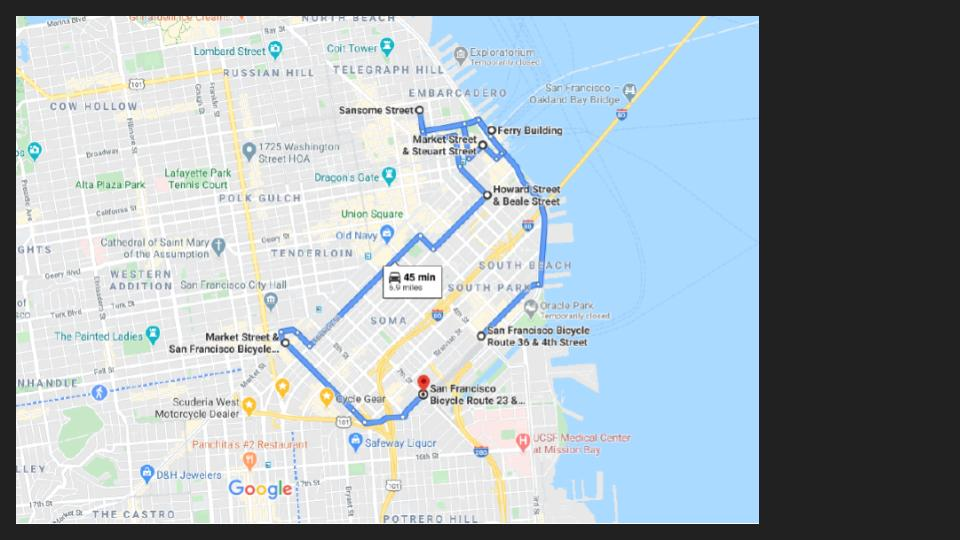

In [104]:
# Using Image function from IPython library to import an image
from IPython.display import Image

# File path of this image will need to be corrected for local image file path
Image(filename='/home/jupyter/w205/project-1-sli0111/df_sf_map.jpg') 

In the above map, most of the trips in San Francisco occur near the financial district and at transportation hubs like: Caltrain, Ferry Building, Transbay Terminal and Bart.  Thus the data suggests a good majority of riders in San Francisco are likely commuters.  To confirm this idea, we can combine the data from time and location.  

The following query reports the trips on weekends and weekdays in the top 10 start stations in San Francisco. First, the dataset from bikeshare_trips is filtered to the start stations defined in df_sf.  Then, the dayofweek extracts the day information from the start_date.  Finally, an if/else statement (using case) sums the trips between Monday to Friday (i.e. 2 to 6) and Sunday and Saturday (i.e. 1 and 7) for each start station separately.    

In [106]:
%%bigquery df_sf_days

SELECT 
    start_station_name,  
    count(*) as trips_started,
    sum(case when day in (2, 3, 4, 5, 6) then 1 else 0 end) as weekday,
    sum(case when day in (1,7) then 1 else 0 end) as weekend
FROM(
    SELECT 
        start_station_id,
        start_station_name,
        trip_id,
        extract(dayofweek from start_date) as day
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE start_station_id in (70, 69, 50, 60, 61, 55, 74, 77, 65, 67)
    )
GROUP BY start_station_name
ORDER BY trips_started DESC
;

The dataframe produced from the query above is edited to add the % weekday trips and % weekend trips out of trips_started.

In [107]:
# Divide the trips started into % weekday and % weekend
df_sf_days['%_weekday'] = round(df_sf_days['weekday']/df_sf_days['trips_started']*100, 2)
df_sf_days['%_weekend'] = round(df_sf_days['weekend']/df_sf_days['trips_started']*100, 2)

df_sf_days

,start_station_name,trips_started,weekday,weekend,%_weekday,%_weekend
0,San Francisco Caltrain (Townsend at 4th),72683,68896,3787,94.79,5.21
1,San Francisco Caltrain 2 (330 Townsend),56100,53299,2801,95.01,4.99
2,Harry Bridges Plaza (Ferry Building),49062,40610,8452,82.77,17.23
3,Embarcadero at Sansome,41137,32345,8792,78.63,21.37
4,2nd at Townsend,39936,35599,4337,89.14,10.86
5,Temporary Transbay Terminal (Howard at Beale),39200,37764,1436,96.34,3.66
6,Steuart at Market,38531,35389,3142,91.85,8.15
7,Market at Sansome,35142,32248,2894,91.76,8.24
8,Townsend at 7th,34894,32182,2712,92.23,7.77
9,Market at 10th,30209,27076,3133,89.63,10.37


With matplotlib and seaborn, a horizontal bar chart is produced to visualize the weekday trips relative to their start stations.

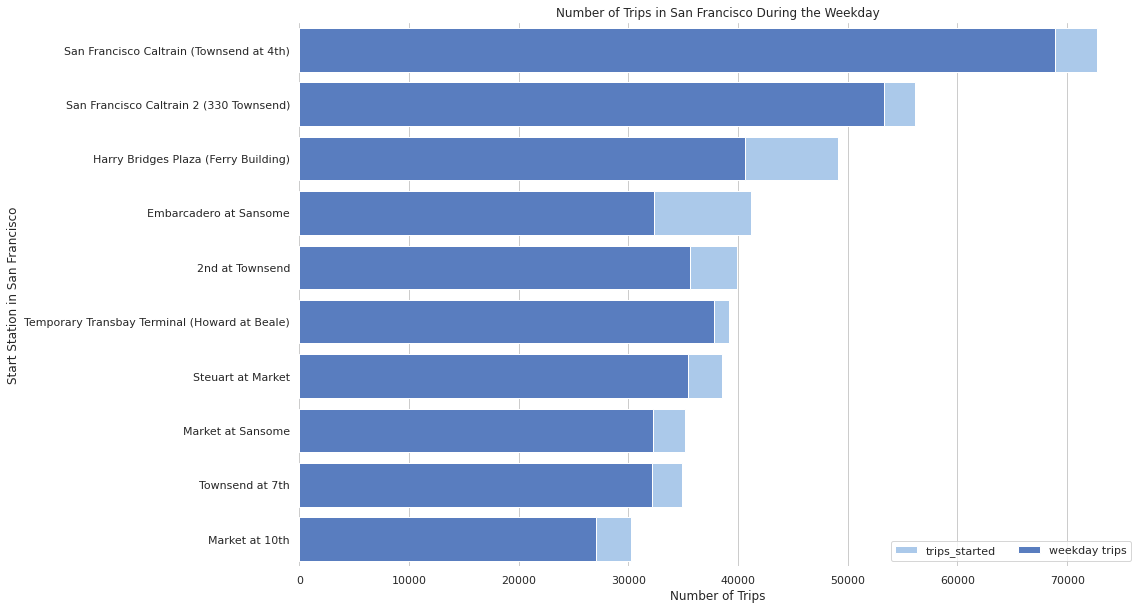

In [44]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))
sns.set(style="whitegrid")

# Plot the number of total trips started
sns.set_color_codes('pastel')
sns.barplot(x="trips_started", y="start_station_name", data=df_sf_days, 
            label='trips_started', color = 'b')

# Plot the number of trips on the weekday
sns.set_color_codes("muted")
sns.barplot(x="weekday", y="start_station_name", data=df_sf_days,
            label="weekday trips", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Start Station in San Francisco",
       xlabel="Number of Trips",
       title="Number of Trips in San Francisco During the Weekday")
sns.despine(left=True, bottom=True)

The table and figure above shows roughly >80% of trips at these popular start stations happen on the weekday.  Since work days happen on weekdays, the graphic further enfources the majority of bikeshare rides are commuters.

Last part of this data exploration look at how the bikeshare trips vary with length of ride.

### 4.  Bikeshare Trips vs Length of Ride

The query below uses the bikeshare_trips dataset and returns a dataframe containing the average duration of bike trips for each start station.  The AVG function calculates the average duration of the ride and is converted to mimutes from seconds.

In [109]:
%%bigquery df_length

SELECT 
    start_station_name, 
    start_station_id, 
    COUNT(start_station_id) as trips_started,
    ROUND(AVG(duration_sec/60),2) as average_trip_length_minutes
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY start_station_name, start_station_id

In [152]:
# Shows dataframe for the average duration of trips for each start station
df_length

,start_station_name,start_station_id,trips_started,average_trip_length_minutes
0,Mezes,83,119,11.31
1,Kaiser Hospital,26,147,10.98
2,Sequoia Hospital,21,15,26.98
3,San Mateo County Center,23,373,39.13
4,Redwood City Public Library,24,272,64.10
...,...,...,...,...
79,California Ave Caltrain Station,36,1418,67.99
80,Charleston Park/ North Bayshore Area,33,343,41.08
81,Stanford in Redwood City,25,864,19.66
82,Evelyn Park and Ride,30,1738,18.72


To visualize the spread of bike durations, we use seaborn to plot a frequency plot.  The x-axis contains bins of trip durations and the y-axis is the frequency of each bin.

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Average Trip Length at Start Stations (minutes)'),
 Text(0.5, 1.0, 'Frequency of Trip Length')]

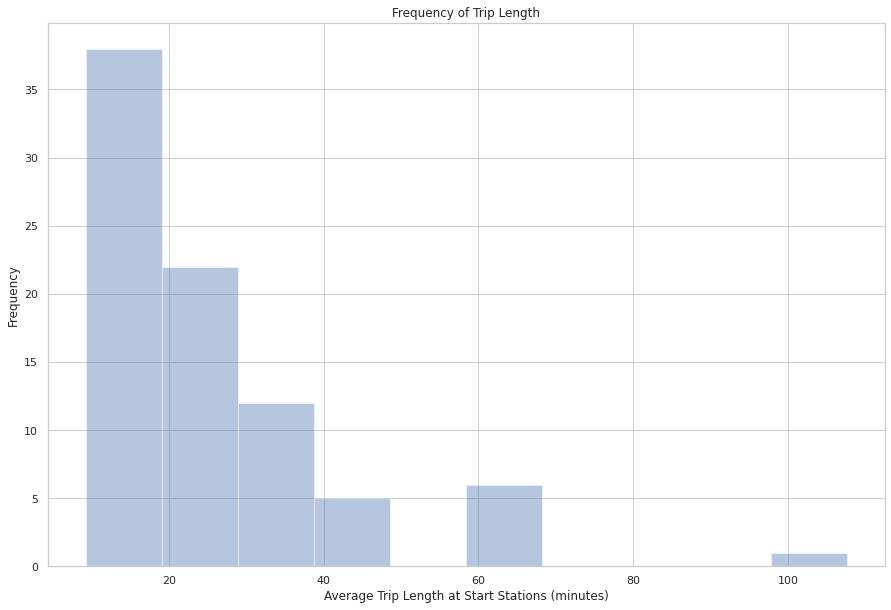

In [63]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))

# Distribution plot of the average trip lengths
sns.distplot(a=df_length['average_trip_length_minutes'], bins=10, kde=False)
ax.set(
    xlabel='Average Trip Length at Start Stations (minutes)',
    ylabel='Frequency',
    title='Frequency of Trip Length')


The distribution of bikes trips are skewed to the right, where >60% of the trips are less than 30 minutes long.  Since the average bike speed is about 15 mph, the typical distances these bikers are traveling is about 7 miles.  Many of the companies in the financial district are within 7 miles of major transportation hubs Caltrain, Ferry Building, Transbay Terminal, and Bart.  Thus the majority of bikeshare riders are commuters that work in the financial district.

### 5. Top 5 Commuter Trips

With the information from sections 0-4, here we define the top 5 commuter trips in this dataset.  A commuter trip will be defined with the following three criteria: 
* starts from the top 10 start stations
* under 30 minutes long
* occurs either at 7-10 am or 4-7 pm.  

Combing some of the queries from prior, we get a query of the bikeshare_trips dataset and implementing the three criteria into the WHERE statement.  Using ORDER BY, the output is a dataframe that list the top 5 commuter trips.

In [112]:
%%bigquery df_commuter_trips

SELECT 
    start_station_id,
    start_station_name,
    count(trip_id) as commuter_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE 
    start_station_id in (70, 69, 50, 60, 61, 55, 74, 77, 65, 67) and
    duration_sec/60 < 30 and
    extract(hour from start_date) in (7, 8, 9, 16, 17, 18)
GROUP BY start_station_name, start_station_id
ORDER BY commuter_trips DESC LIMIT 5
;

In [113]:
# Create a new row that sums the trips from the top 5 commuter trips
new_row = pd.DataFrame(
    {'start_station_id':' ',
     'start_station_name':'Top 5 Commuter Trips', 
     'commuter_trips':sum(df_commuter_trips['commuter_trips'])},
     index =[0])

# Add the row to the df_commuter_trips dataframe
df_commuter_trips = pd.concat([new_row, df_commuter_trips]).reset_index(drop = True)

# Display the top 5 commuter trips dataframe
df_commuter_trips

,start_station_id,start_station_name,commuter_trips
0,,Top 5 Commuter Trips,177199
1,70,San Francisco Caltrain (Townsend at 4th),53145
2,69,San Francisco Caltrain 2 (330 Townsend),40971
3,55,Temporary Transbay Terminal (Howard at Beale),29132
4,50,Harry Bridges Plaza (Ferry Building),28231
5,74,Steuart at Market,25720


Given the criteria of a commuter trip, the top 5 trips are those presented in the above data frame.  These trips:
* start at San Francisco Caltrain, Transbay Terminal, and/or Ferry Building
* occurs for less than 30 minutes
* and in the morning/evening between 7-10am and 4-7pm
       
The top 5 commuter trips also account for 18% of the all trips.  Additionally, the data so far suggest we are doing a good job attracting ridership during commuting hours.

### 6. Recommendations for New Membership

To understand where we lack in membership we will look at four questions:
* Are there still options in coverting customers to subscribers during the commuting hours?
* Which stations have the least amount of start trips in San Francisco?
* How is the ratio of subscribers and customers changing throughout the year?
* How long are customers riding?

#### 6a. Are there still options in converting more customers to subscribers during commute days and hours?

The query below uses the bikeshare_trips dataset and produces a dataframe containing the number of subscribers and customers during commute hours.  The script filters the dataset to weekday and peak working hours and then uses the if/else statement to sum up the number of subscribers and customers for each station.

In [115]:
%%bigquery df_commuting_subscriber

SELECT 
  start_station_name, 
  count(*) as Total_Trips,
  sum(case when subscriber_type = 'Subscriber' then 1 else 0 end) as Subscriber,
  sum(case when subscriber_type = 'Customer' then 1 else 0 end) as Customer
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE 
    extract(hour from start_date) in (7, 8, 9, 16, 17, 18) and
    extract(dayofweek from start_date) in (2, 3, 4, 5, 6)
GROUP BY start_station_name 
ORDER BY Total_Trips DESC LIMIT 10
;

The dataframe is edited to calculate the percentage of subscribers out of the total trips

In [153]:
# Adding new column
df_commuting_subscriber["Percent_Subscriber"] = round(df_commuting_subscriber["Subscriber"]/df_commuting_subscriber["Total_Trips"] * 100, 2)

# Display the dataframe
df_commuting_subscriber

,start_station_name,Total_Trips,Subscriber,Customer,Percent_Subscriber
0,San Francisco Caltrain (Townsend at 4th),52441,50832,1609,96.93
1,San Francisco Caltrain 2 (330 Townsend),40264,39319,945,97.65
2,Temporary Transbay Terminal (Howard at Beale),28880,28448,432,98.50
3,Harry Bridges Plaza (Ferry Building),27298,25002,2296,91.59
4,Steuart at Market,25313,24173,1140,95.50
5,2nd at Townsend,24103,23183,920,96.18
6,Townsend at 7th,20323,19669,654,96.78
7,Market at Sansome,18880,18037,843,95.53
8,Embarcadero at Sansome,18587,15782,2805,84.91
9,Market at 10th,17273,16457,816,95.28


For the most part, our most popular stations have >95% subscriber membership.  However, we can focus some efforts to improve membership at the Ferry Building and the Embarcadero at Sansome which have only about 90% subscriber membership.  

Both locations are hubs for transportation: one for the ferry and the other for Muni.  One recommendation is to include a membership that incentives ferry and Muni riders, such as an initially discounted rate.

#### 6b. Which stations have the least amount of start trips in San Francisco?

The following query uses both the bikeshare_trips and bikeshare_stations dataset to produce a dataframe containing the 10 least used start stations.  The script joins both datasets using start_station_id and station_id and filters the landmarks to San Francisco only.  

In [117]:
%%bigquery df_least

SELECT
    start_station_id,
    landmark,
    start_station_name,
    count(trip_id) as trips_started,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations`
ON start_station_id = station_id
WHERE landmark = 'San Francisco'
GROUP BY start_station_id, start_station_name, landmark
ORDER BY trips_started ASC LIMIT 10
;

The dataframe is edited to include a summation row

In [118]:
# Create a new row to sum the total number of trips in the least 10
new_row = pd.DataFrame(
    {'start_station_id':' ',
     'landmark':'',
     'start_station_name':'Top 10 Least Started Stations', 
     'trips_started':sum(df_least['trips_started'])},
     index =[0])

# Add the row to the dataframe
df_least = pd.concat([new_row, df_least]).reset_index(drop = True)

# Display the dataframe
df_least

,start_station_id,landmark,start_station_name,trips_started
0,,,Top 10 Least Started Stations,69104
1,91,San Francisco,Cyril Magnin St at Ellis St,69
2,90,San Francisco,5th St at Folsom St,173
3,46,San Francisco,Washington at Kearney,1472
4,47,San Francisco,Post at Kearney,2503
5,58,San Francisco,San Francisco City Hall,6730
6,46,San Francisco,Washington at Kearny,7136
7,59,San Francisco,Golden Gate at Polk,10651
8,47,San Francisco,Post at Kearny,11308
9,41,San Francisco,Clay at Battery,14351


San Francisco had a total of 891,223 trips and the above 10 trips account for <10% of the total.  These areas are in the Tenderloin and between Union Square and Chinatown.  These three neighborhoods are very unique to San Francisco especially for the food and culture.  Additionally, transportation by car is often difficult in these neighborhoods due to traffic congestion and limited parking but make it a good opportunity for bikes.  

One opportunity to increase membership in these neighborhoods is to offer a "ride+eat" membership where riders can get deals with local restaurants and stores.  Another opportunity is to create a partnership with food delivery companies like Grubhub to efficiently deliver food in these congested areas.

#### 6c.  How is the ratio of subscribers and customers changing throughout the year?

From 6a, we saw that the majority of the popular stations were subscribers.  However, lets also look at how the number of customers change throughout the year.

The following query uses the bikeshare_trips dataset and returns a dataframe containing the number of customers each month.  With the if/else statement (case) the number of customers are summed up for each month.

In [134]:
%%bigquery df_month_winter

SELECT 
    EXTRACT(month from start_date) as months,
    COUNT(trip_id) as trips_started,
    ROUND(COUNT(trip_id) / 983648 *100, 2) as percent_of_total_rides,
    sum(case when subscriber_type = 'Subscriber' then 1 else 0 end) as Subscriber,
    sum(case when subscriber_type = 'Customer' then 1 else 0 end) as Customer
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY months
ORDER BY percent_of_total_rides DESC;

The dataframe is edited to calculate the proportion of customers

In [154]:
# Add additional row
df_month_winter['%_customer'] = round(df_month_winter['Customer']/df_month_winter['trips_started'] * 100, 2)

# Display the dataframe
df_month_winter

,months,trips_started,percent_of_total_rides,Subscriber,Customer,%_customer
0,8,95576,9.72,80033,15543,16.26
1,10,94378,9.59,80340,14038,14.87
2,6,91672,9.32,79525,12147,13.25
3,7,89539,9.10,76387,13152,14.69
4,9,87321,8.88,70011,17310,19.82
5,5,86364,8.78,73623,12741,14.75
6,4,84196,8.56,74218,9978,11.85
7,3,81777,8.31,71619,10158,12.42
8,11,73091,7.43,63720,9371,12.82
9,1,71788,7.30,64075,7713,10.74


[Text(0, 0.5, '% of Customers out of Total'),
 Text(0.5, 0, 'Months'),
 Text(0.5, 1.0, 'Ratio of Customers vs Months')]

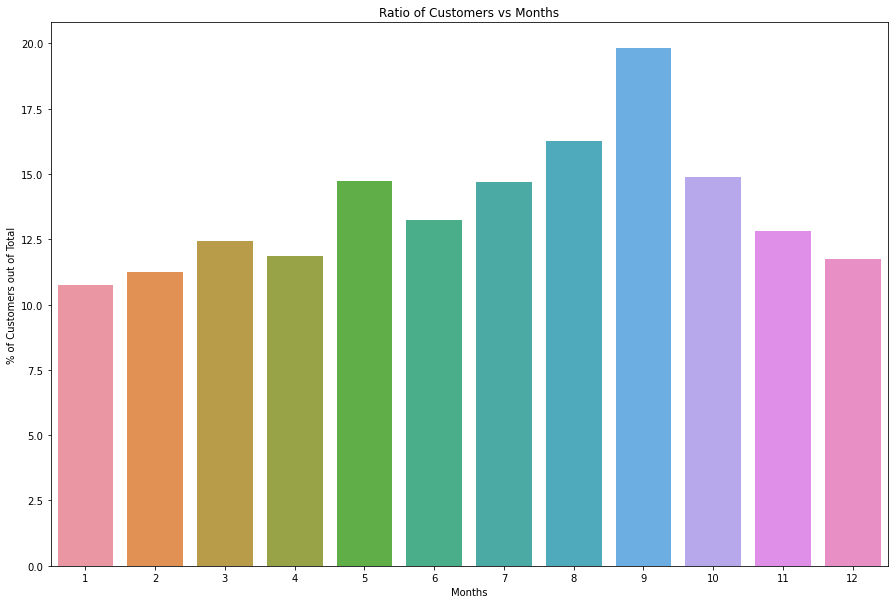

In [141]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the barplots for monthly, daily, and hourly datasets
ax1 = sns.barplot(x="months", y="%_customer", data=df_month_winter)

# Label the axis and titles
ax.set(
    xlabel='Months',
    ylabel='% of Customers out of Total',
    title='Ratio of Customers vs Months')

From the graphic, the % of customer actually reaches a peak in September.  A potential reason maybe these customers are students that move into the bayarea before school starts.  If this is the case, offering student memberships during this time may convert these one-time users into members.

#### 6d. How long are customers riding?

The query below uses the bikeshare_trips dataset and outputs a dataframe containing the the average riding time for customers starting from several stations.  The AVG function is used to compute the average riding time in minutes and case is used to sum up the number of customers for those rides.

In [150]:
%%bigquery df_stations_customers

SELECT
    start_station_name,
    count(trip_id) as trips_started,
    ROUND(AVG(duration_sec/60),2) as average_trip_length_minutes,
    sum(case when subscriber_type = 'Customer' then 1 else 0 end) as Customer
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY start_station_name
ORDER BY Customer DESC LIMIT 10
;

Display the dataframe

In [151]:
df_stations_customers

,start_station_name,trips_started,average_trip_length_minutes,Customer
0,Embarcadero at Sansome,41137,22.13,13934
1,Harry Bridges Plaza (Ferry Building),49062,22.74,12441
2,Market at 4th,27502,20.65,5952
3,Powell Street BART,25204,22.02,5214
4,Embarcadero at Vallejo,15302,24.86,4945
5,Powell at Post (Union Square),16984,25.11,4932
6,Steuart at Market,38531,14.35,4469
7,2nd at Townsend,39936,12.48,4436
8,San Francisco Caltrain (Townsend at 4th),72683,13.41,4299
9,Market at Sansome,35142,14.30,3874


The top 10 popular stations for customers are in San Francisco and they take rides that are less than 25 minutes long.  The pricing for a one-time user is currently $2 for 30 minutes.  When these customers sign up for these rides in the app, they should also be offered a discounted monthly membership.  The competitive pricing may entice the customers to sign up for a monthly membership for just a few dollars more.

#### 6e. Gathering the results from 6a to 6d, the recommendations to increase membership are:
* Create memberships to incentivize ferry and Muni commuters to use our bikeshare bikes for their second mode of transportation
* Create 'ride+eat' membership for riders to get deals at local shops and to create partnerships with food delivery companies
* Create 'student' membership for students who arrive to the bayarea during the fall
* Create ads to entice one-time users to sign up for monthly membership because of a competitive price.

### 7. Conclusion

In conclusion, the bikeshare datasets show we are doing a very good job getting commuters to join the bikeshare membership.  However there are still opportunities for other types of audiences such as multiple transportation commuters, foodies, students, and other one-time users.